# Case study: US daily Covid 19 data

## Importing required libraries

In [2]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from statsmodels.tsa.api                  import  ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## importing data

In [5]:
df=pd.read_csv('us_covid19_daily-1.csv',parse_dates=True)

In [6]:
df.head()

,Date,Positive,Hospitalized,Death
0,17-03-2020,10021,325,124
1,18-03-2020,13385,416,155
2,19-03-2020,18085,617,203
3,20-03-2020,24197,1042,273
4,21-03-2020,31013,1492,335


In [7]:
df.tail()

,Date,Positive,Hospitalized,Death
260,02-12-2020,13711156,100322,264522
261,03-12-2020,13921360,100755,267228
262,04-12-2020,14146191,101276,269791
263,05-12-2020,14357264,101190,272236
264,06-12-2020,14534035,101487,273374


### Data is collecetd for the period of 17th March 2020 to 06th December 2020. Data is collected on daily basis for Positive cases, Hospitalized and Death count

## converting data into time series

In [8]:
date = pd.date_range(start='3/17/2020', end='12/6/2020', freq='D')
date

DatetimeIndex(['2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26',
               ...
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06'],
              dtype='datetime64[ns]', length=265, freq='D')

In [9]:
df['Time_Stamp'] = pd.DataFrame(date)

In [10]:
df=df.set_index('Time_Stamp')

In [11]:
df.head()

,Date,Positive,Hospitalized,Death
Time_Stamp,,,,
2020-03-17,17-03-2020,10021,325,124
2020-03-18,18-03-2020,13385,416,155
2020-03-19,19-03-2020,18085,617,203
2020-03-20,20-03-2020,24197,1042,273
2020-03-21,21-03-2020,31013,1492,335


In [12]:
df.tail()

,Date,Positive,Hospitalized,Death
Time_Stamp,,,,
2020-12-02,02-12-2020,13711156,100322,264522
2020-12-03,03-12-2020,13921360,100755,267228
2020-12-04,04-12-2020,14146191,101276,269791
2020-12-05,05-12-2020,14357264,101190,272236
2020-12-06,06-12-2020,14534035,101487,273374


### For this case study, we will build time series model to forecast the Hospitalized count

## plotting variable Hospitalized 

<AxesSubplot:xlabel='Time_Stamp'>

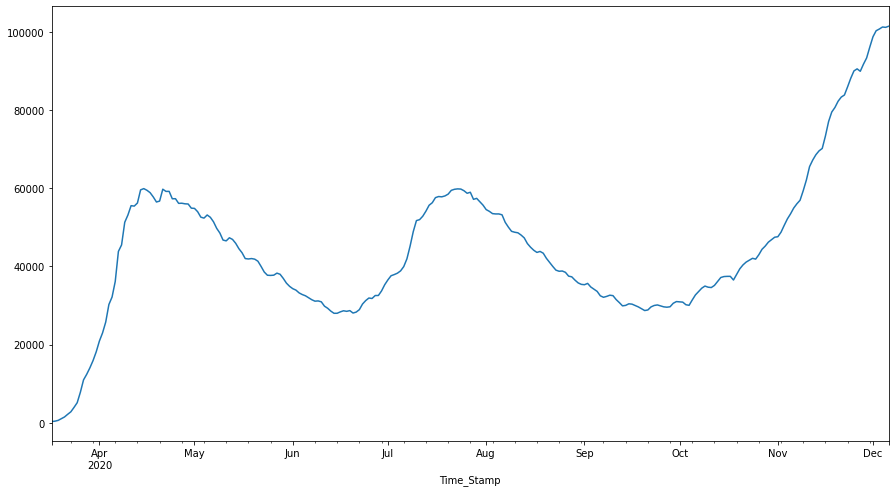

In [13]:
rcParams['figure.figsize'] = 15,8
df['Hospitalized'].plot()

Inferences:
    
There are no Long term Seasonality

In [14]:
df_final=df.drop(['Date','Positive','Death'],axis=1)

In [17]:
df_final.head()

,Hospitalized
Time_Stamp,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [15]:
df_final.tail()

,Hospitalized
Time_Stamp,
2020-12-02,100322
2020-12-03,100755
2020-12-04,101276
2020-12-05,101190
2020-12-06,101487


## Checking for Null values

In [16]:
df_final.isnull().sum()

Hospitalized    0
dtype: int64

### data does not have any missing values

## Exploratory Data Analysis

In [18]:
rcParams['figure.figsize'] = 10,6

<AxesSubplot:xlabel='Time_Stamp'>

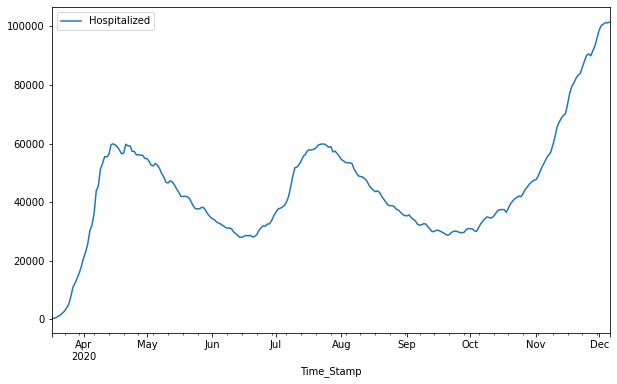

In [19]:
df_final.plot()

### plotting box-plot for distribution of data

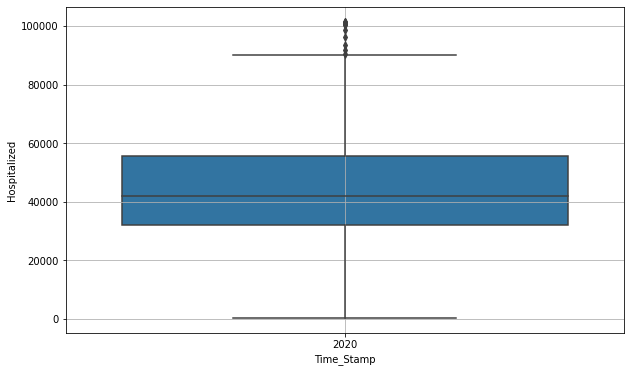

In [20]:
sns.boxplot(x = df_final.index.year,y = df_final['Hospitalized'])
plt.grid();

### data does not show any skewness

## plotting monthwise distribution

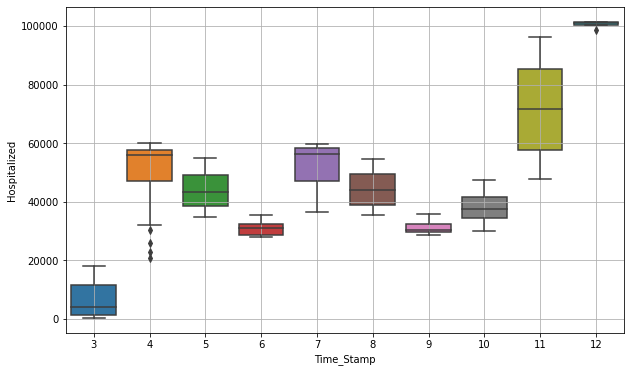

In [21]:
sns.boxplot(x = df_final.index.month,y = df_final['Hospitalized'])
plt.grid();

### High variation in data can be observed in the month of November. Few outliers are present in the month of April

## Decomposing time series

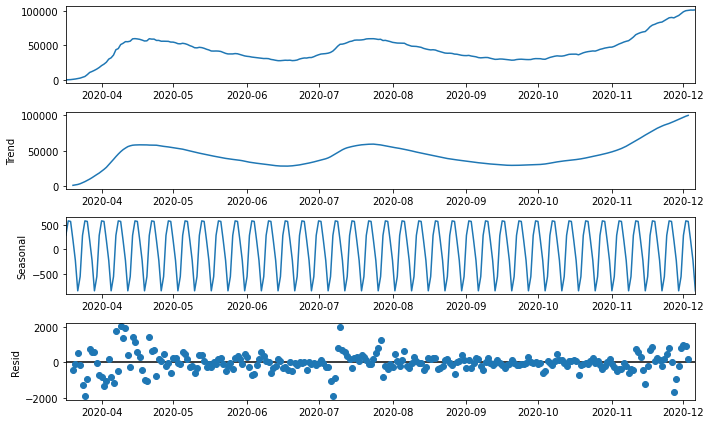

In [22]:
decomposition = seasonal_decompose(df_final, model = 'additive',period=7)
decomposition.plot()
plt.show()

Inferences:
    
99% of data is well understood by Trend Complement

Residuals are not having Constant variance at few intervals whereas the other residuals are close to 0

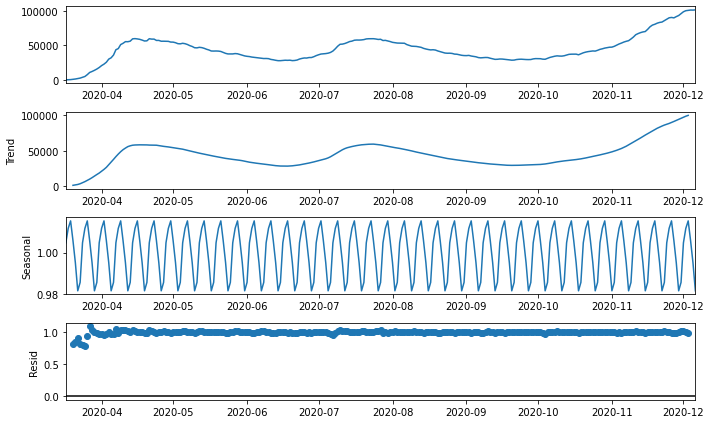

In [23]:
decomposition = seasonal_decompose(df_final, model = 'multiplicative')
decomposition.plot()
plt.show()

### Time series is showing trend as well as seasonality. Residual curve confirms that series is Multiplicative

There is some sort of Seasonality but it is Trend which gives us more Information

## Looking for stationarity

### plotting monthly mean

<AxesSubplot:xlabel='Time_Stamp'>

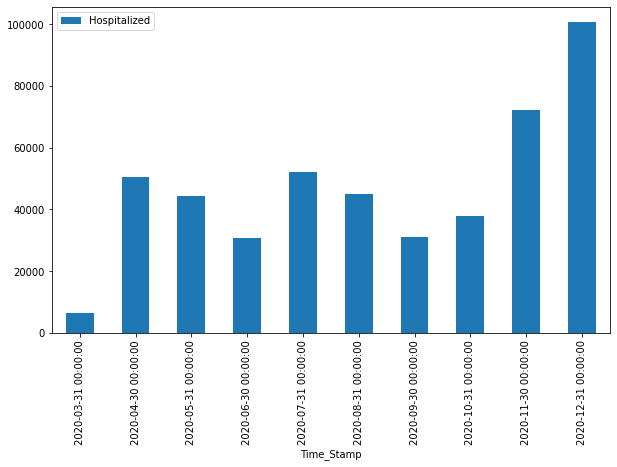

In [24]:
monthly_mean = df_final.resample('M').mean()
monthly_mean.plot.bar()

### Variation in monthly mean plot is indicating that series is non-stationary

## lets plot rolling mean and std deviation

In [26]:
rolmean = df_final.rolling(window=30).mean()
rolstd = df_final.rolling(window=30).std()

Here window can be taken any range since we are dealing with Daily Data

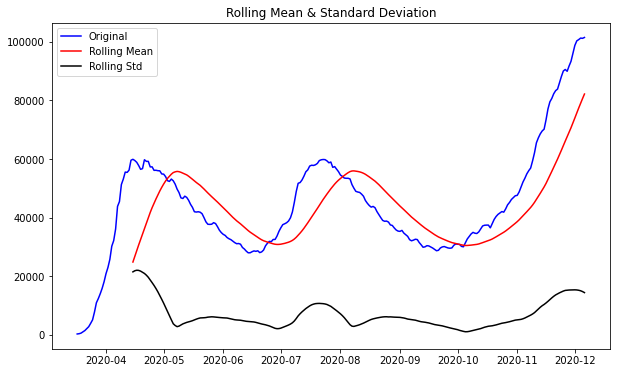

In [27]:
orig = plt.plot(df_final, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

### both rolling mean and std deviation are changing over the period of time

## statistical test to confirm the stationarity.

Not a Stationary Series

In [28]:
observations= df_final.values
test_result = adfuller(observations)

In [29]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -1.631167
p-value: 0.466880
Critical Values:
	1%: -3.45700
	5%: -2.87327
	10%: -2.57302


ADF Statistic and p_value > 1% (995) value

### Test result confirms that series is non-stationary

## ACF and PACF plots for the series

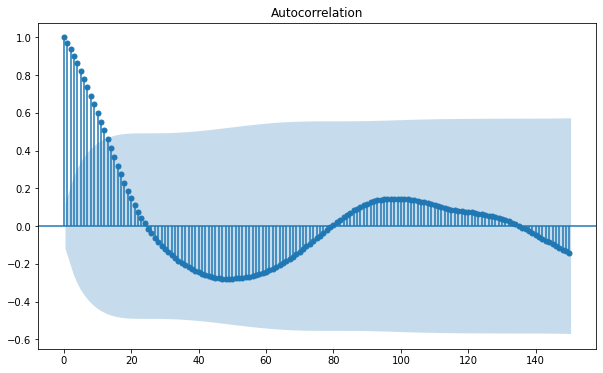

In [34]:
plot_acf(df_final,lags=150);

There is a slow decay over a period of time and also there are 12 lags which are Significant and then there is a drop. Hence we dont consider ACF

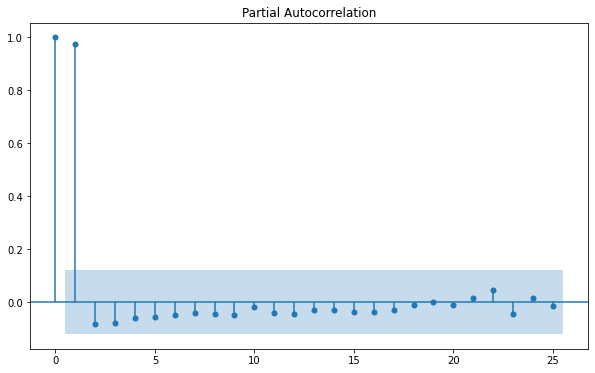

In [31]:
plot_pacf(df_final);

### ACF plot is showing gradual decay and it shows Seasonal nature but it is very weak.

### whereas PACF is showing short cut-off after Lag1. This indicates strong trend component.

### It seems that time series may have AR signature

## Splitting series into training and testing sets

In [35]:
df_final.head()

,Hospitalized
Time_Stamp,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [36]:
df_final.tail()

,Hospitalized
Time_Stamp,
2020-12-02,100322
2020-12-03,100755
2020-12-04,101276
2020-12-05,101190
2020-12-06,101487


In [37]:
train_end=datetime(2020,11,6)
test_end=datetime(2020,12,6)

In [38]:
train             = df_final[:train_end] 
test              = df_final[train_end + timedelta(days=1):test_end]

In [39]:
train.shape

(235, 1)

In [40]:
test.shape

(30, 1)

## Model Selection

### As the given time series is non-stationary, we will the forecasting model using ARIMA, SARIMA and SARIMAX model. We will also build the H-W forecasting model.

### Let's start by building ARIMA model -- Although the data set has some seasonality and hence ARIMA is not the right option for making the model.

## we will find the model parameters based on AIC criteria. Parameters will be  generated using combination for the given range.

In [41]:
import itertools
p = q = range(0, 4)
d= range(0,2)
pdq = list(itertools.product(p, d, q))

#model_pdq = [(x[0], x[1], x[2],7) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Model...')
#print('Model: {}{}'.format(pdq[1], model_pdq[1]))
#print('Model: {}{}'.format(pdq[1], model_pdq[2]))
#print('Model: {}{}'.format(pdq[2], model_pdq[3]))
#print('Model: {}{}'.format(pdq[2], model_pdq[4]))

In [42]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

## Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [43]:
dfObj1 = pd.DataFrame(columns=['param', 'AIC'])
dfObj1

,param,AIC


## model parameter selection using hypertuning

In [44]:
for param in pdq:
            try:
                mod = ARIMA(train, order=param)
                results_Arima = mod.fit()
                print('ARIMA{} - AIC:{}'.format(param, results_Arima.aic))
                dfObj1 = dfObj1.append({'param':param, 'AIC': results_Arima.aic}, ignore_index=True)

            except:
                continue

ARIMA(0, 0, 0) - AIC:5135.977286705961
ARIMA(0, 0, 1) - AIC:4839.912200774063
ARIMA(0, 1, 0) - AIC:4010.2897353658404
ARIMA(0, 1, 1) - AIC:3939.069525837872
ARIMA(0, 1, 2) - AIC:3898.0799435165954
ARIMA(0, 1, 3) - AIC:3868.531341318412
ARIMA(1, 0, 0) - AIC:4043.8294100225767
ARIMA(1, 0, 1) - AIC:3969.9372777096
ARIMA(1, 0, 2) - AIC:3927.3178289265616
ARIMA(1, 0, 3) - AIC:3896.412783237557
ARIMA(1, 1, 0) - AIC:3876.862767738583
ARIMA(1, 1, 1) - AIC:3852.8584457433
ARIMA(1, 1, 2) - AIC:3853.565781010923
ARIMA(1, 1, 3) - AIC:3851.41281301214
ARIMA(2, 0, 0) - AIC:3902.5124509088555
ARIMA(2, 0, 1) - AIC:3866.482215806256
ARIMA(2, 0, 2) - AIC:3863.8773474948885
ARIMA(2, 0, 3) - AIC:3860.260483656474
ARIMA(2, 1, 0) - AIC:3857.2086739242623
ARIMA(2, 1, 1) - AIC:3852.9898073417867
ARIMA(2, 1, 2) - AIC:3854.565738574014
ARIMA(2, 1, 3) - AIC:3853.4028312609935
ARIMA(3, 0, 0) - AIC:3880.4097411640173
ARIMA(3, 0, 1) - AIC:3862.5288620771885
ARIMA(3, 0, 2) - AIC:3863.903013879052
ARIMA(3, 0, 3) - AI

In [45]:
dfObj1.sort_values(by=['AIC'])

,param,AIC
29,"(3, 1, 3)",3828.787187
13,"(1, 1, 3)",3851.412813
11,"(1, 1, 1)",3852.858446
19,"(2, 1, 1)",3852.989807
21,"(2, 1, 3)",3853.402831
12,"(1, 1, 2)",3853.565781
27,"(3, 1, 1)",3853.606468
20,"(2, 1, 2)",3854.565739
28,"(3, 1, 2)",3854.716046
18,"(2, 1, 0)",3857.208674


In [46]:
model = ARIMA(train, order=(3, 1, 3))

model_Arima = model.fit()

print(model_Arima.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Hospitalized   No. Observations:                  234
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1906.394
Method:                       css-mle   S.D. of innovations            830.751
Date:                Wed, 12 May 2021   AIC                           3828.787
Time:                        10:06:48   BIC                           3856.430
Sample:                    03-18-2020   HQIC                          3839.933
                         - 11-06-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  303.4195    379.167      0.800      0.424    -439.733    1046.572
ar.L1.D.Hospitalized     1.5418      0.068     22.526      0.000       1.408       1.676
ar.L2.D.Hosp

## predicting results

In [47]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [48]:
ARIMA_predictions=model_Arima.predict(start=pred_start, end=pred_end)

In [51]:
ARIMA_predictions

2020-11-07     778.616381
2020-11-08     857.179505
2020-11-09    1107.249730
2020-11-10    1156.440340
2020-11-11     963.503162
2020-11-12     775.826627
2020-11-13     769.967682
2020-11-14     869.761728
2020-11-15     901.076071
2020-11-16     816.296971
2020-11-17     714.295848
2020-11-18     688.328982
2020-11-19     721.362932
2020-11-20     735.139749
2020-11-21     695.676200
2020-11-22     639.925792
2020-11-23     614.532957
2020-11-24     620.085436
2020-11-25     622.816220
2020-11-26     602.243373
2020-11-27     570.843582
2020-11-28     550.917450
2020-11-29     546.519650
2020-11-30     543.725662
2020-12-01     531.287038
2020-12-02     512.671380
2020-12-03     498.110893
2020-12-04     491.100431
2020-12-05     486.206080
2020-12-06     477.626523
Freq: D, dtype: float64

## invert transformation

In [52]:
ARIMA_pred=ARIMA_predictions.cumsum()
ARIMA_pred=pd.DataFrame(ARIMA_pred,columns=train.columns)

In [53]:
df_fc = ARIMA_pred.copy()
columns = train.columns
for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)]

The last element of Train record is added to the first record of Test

In [54]:
df_fc.head()

,Hospitalized,Hospitalized_forecast
2020-11-07,778.616381,55727.616381
2020-11-08,1635.795886,56584.795886
2020-11-09,2743.045616,57692.045616
2020-11-10,3899.485957,58848.485957
2020-11-11,4862.989119,59811.989119


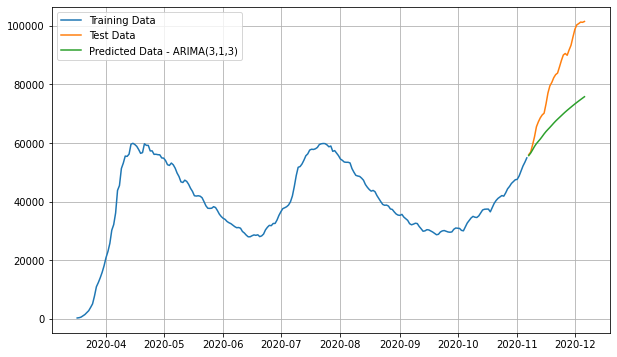

In [67]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA(3,1,3)')
plt.legend(loc='best')
plt.grid();

In this ARIMA Captures Trend component.

The behaviour of Test is different from Train. 

Since the forecast for the Test data is flattened

From above the test is nearly 80000 but the forecast shows just 60000 hence this will be considered Under Forecast.

## finding model residuals

In [68]:
residuals = test.Hospitalized - df_fc['Hospitalized_forecast']

In [69]:
residuals

Time_Stamp
2020-11-07      309.383619
2020-11-08      357.204114
2020-11-09     1701.954384
2020-11-10     3289.514043
2020-11-11     5745.010881
2020-11-12     6645.184254
2020-11-13     7241.216572
2020-11-14     7360.454844
2020-11-15     7073.378773
2020-11-16     9432.081802
2020-11-17    12419.785953
2020-11-18    14169.456972
2020-11-19    14613.094040
2020-11-20    15474.954291
2020-11-21    15846.278091
2020-11-22    15742.352298
2020-11-23    17224.819341
2020-11-24    18799.733905
2020-11-25    20043.917685
2020-11-26    19964.674312
2020-11-27    18779.830730
2020-11-28    20040.913280
2020-11-29    21089.393630
2020-11-30    23337.667967
2020-12-01    25434.380929
2020-12-02    26466.709549
2020-12-03    26401.598656
2020-12-04    26431.498225
2020-12-05    25859.292145
2020-12-06    25678.665622
dtype: float64

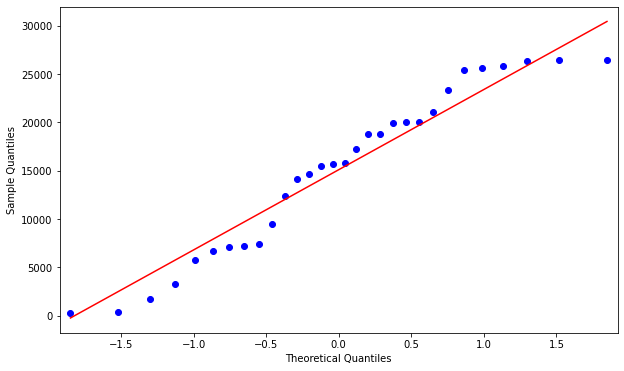

In [70]:
qqplot(residuals,line="s");

In [71]:
sns.displot(residuals,bins=6)

AttributeError: module 'seaborn' has no attribute 'displot'

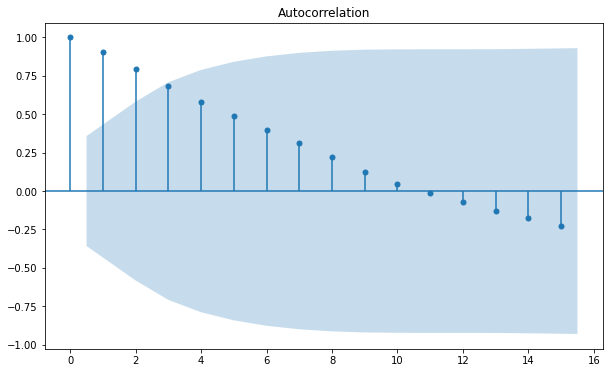

In [72]:
plot_acf(residuals);

### distribution of residual plot confirms that model does not fit well with the seasonality series

## Calculating RSME and MAPE 

In [73]:
from math import sqrt
from sklearn.metrics import  mean_squared_error
rmse = sqrt(mean_squared_error(test.Hospitalized,df_fc['Hospitalized_forecast']))
print(rmse)

17232.76041754542


In [74]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [75]:
mape = MAPE(test['Hospitalized'].values,df_fc['Hospitalized_forecast'].values)
print(mape)

17.04045015827317


## creating new dataframe for storing the results

In [77]:
resultsDf = pd.DataFrame({'Test RMSE': rmse,'Test MAPE':mape}
                           ,index=['ARIMA(3,1,3)'])

resultsDf

,Test RMSE,Test MAPE
"ARIMA(3,1,3)",17232.760418,17.04045


## Now to include seasonality, we will use SARIMA model

## we will find the model parameters based on AIC criteria. Parameters will be  generated using combination for the given range.

In [78]:
import itertools
p = q = range(0, 4)
d= range(0,2)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 0, 2, 7)
Model: (0, 0, 2)(0, 0, 3, 7)
Model: (0, 0, 2)(0, 1, 0, 7)


## Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [79]:
dfObj2 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
dfObj2

,param,seasonal,AIC


## model parameter selection using hypertuning

In [80]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = mod.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        dfObj2 = dfObj2.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:5648.332882628767
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:5329.355924738477
SARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:5115.053922132147
SARIMA(0, 0, 0)x(0, 0, 3, 7)7 - AIC:4934.120728925338
SARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:4680.257455970985
SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:4461.06443246171
SARIMA(0, 0, 0)x(0, 1, 2, 7)7 - AIC:4318.236654607667
SARIMA(0, 0, 0)x(0, 1, 3, 7)7 - AIC:3942.8320661846683
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:4701.52192186462
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:4720.920611046692
SARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:4286.839422252497
SARIMA(0, 0, 0)x(1, 0, 3, 7)7 - AIC:4295.099961686247
SARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:4377.198345433431
SARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:4336.6448075317985
SARIMA(0, 0, 0)x(1, 1, 2, 7)7 - AIC:4156.795793351504
SARIMA(0, 0, 0)x(1, 1, 3, 7)7 - AIC:3913.0428056526466
SARIMA(0, 0, 0)x(2, 0, 0, 7)7 - AIC:4374.716096873708
SARIMA(0, 0, 0)x(2, 0, 1, 7)7 - AIC:4363.917302887574
SARIMA(0, 0, 0)x(2, 0, 2, 7

SARIMA(0, 1, 0)x(3, 0, 0, 7)7 - AIC:3459.4912695956073
SARIMA(0, 1, 0)x(3, 0, 1, 7)7 - AIC:3461.472230589201
SARIMA(0, 1, 0)x(3, 0, 2, 7)7 - AIC:3450.9646828964005
SARIMA(0, 1, 0)x(3, 0, 3, 7)7 - AIC:3435.4842616526767
SARIMA(0, 1, 0)x(3, 1, 0, 7)7 - AIC:3384.5477200828927
SARIMA(0, 1, 0)x(3, 1, 1, 7)7 - AIC:3369.9653123003372
SARIMA(0, 1, 0)x(3, 1, 2, 7)7 - AIC:3362.795159070214
SARIMA(0, 1, 0)x(3, 1, 3, 7)7 - AIC:3348.0772063151544
SARIMA(0, 1, 1)x(0, 0, 0, 7)7 - AIC:3910.4415322598707
SARIMA(0, 1, 1)x(0, 0, 1, 7)7 - AIC:3755.8553045739773
SARIMA(0, 1, 1)x(0, 0, 2, 7)7 - AIC:3597.5403389699786
SARIMA(0, 1, 1)x(0, 0, 3, 7)7 - AIC:3374.9007763831833
SARIMA(0, 1, 1)x(0, 1, 0, 7)7 - AIC:3784.93121953064
SARIMA(0, 1, 1)x(0, 1, 1, 7)7 - AIC:3637.7118560623567
SARIMA(0, 1, 1)x(0, 1, 2, 7)7 - AIC:3456.8744402645607
SARIMA(0, 1, 1)x(0, 1, 3, 7)7 - AIC:3288.687267844857
SARIMA(0, 1, 1)x(1, 0, 0, 7)7 - AIC:3767.0481217105043
SARIMA(0, 1, 1)x(1, 0, 1, 7)7 - AIC:3728.1918488102783
SARIMA(0, 1, 1)

SARIMA(1, 0, 1)x(1, 1, 3, 7)7 - AIC:3351.050610841837
SARIMA(1, 0, 1)x(2, 0, 0, 7)7 - AIC:3666.340860340162
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:3622.554324610877
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:3635.706344412598
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:3496.5276724421547
SARIMA(1, 0, 1)x(2, 1, 0, 7)7 - AIC:3501.83329626351
SARIMA(1, 0, 1)x(2, 1, 1, 7)7 - AIC:3500.4373926452663
SARIMA(1, 0, 1)x(2, 1, 2, 7)7 - AIC:3456.5245458380577
SARIMA(1, 0, 1)x(2, 1, 3, 7)7 - AIC:3354.3324200969537
SARIMA(1, 0, 1)x(3, 0, 0, 7)7 - AIC:3437.2373554863584
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:3507.84716158062
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:3511.867626288987
SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:3497.2106637883435
SARIMA(1, 0, 1)x(3, 1, 0, 7)7 - AIC:3342.9415615162106
SARIMA(1, 0, 1)x(3, 1, 1, 7)7 - AIC:3344.2895583606683
SARIMA(1, 0, 1)x(3, 1, 2, 7)7 - AIC:3331.690442379855
SARIMA(1, 0, 1)x(3, 1, 3, 7)7 - AIC:3349.094699428706
SARIMA(1, 0, 2)x(0, 0, 0, 7)7 - AIC:3878.7587819032115
SARIMA(1, 0, 2)x(0, 0

SARIMA(1, 1, 2)x(0, 1, 2, 7)7 - AIC:3323.8177252641076
SARIMA(1, 1, 2)x(0, 1, 3, 7)7 - AIC:3191.5220205499827
SARIMA(1, 1, 2)x(1, 0, 0, 7)7 - AIC:3682.253912070631
SARIMA(1, 1, 2)x(1, 0, 1, 7)7 - AIC:3628.1390997975573
SARIMA(1, 1, 2)x(1, 0, 2, 7)7 - AIC:3502.3247149948893
SARIMA(1, 1, 2)x(1, 0, 3, 7)7 - AIC:3306.826454376229
SARIMA(1, 1, 2)x(1, 1, 0, 7)7 - AIC:3577.7256435943896
SARIMA(1, 1, 2)x(1, 1, 1, 7)7 - AIC:3514.567710147103
SARIMA(1, 1, 2)x(1, 1, 2, 7)7 - AIC:3322.2536773061556
SARIMA(1, 1, 2)x(1, 1, 3, 7)7 - AIC:3187.0289892129076
SARIMA(1, 1, 2)x(2, 0, 0, 7)7 - AIC:3548.6044048795416
SARIMA(1, 1, 2)x(2, 0, 1, 7)7 - AIC:3540.586626698346
SARIMA(1, 1, 2)x(2, 0, 2, 7)7 - AIC:3498.712624342279
SARIMA(1, 1, 2)x(2, 0, 3, 7)7 - AIC:3308.629035464151
SARIMA(1, 1, 2)x(2, 1, 0, 7)7 - AIC:3397.832582183522
SARIMA(1, 1, 2)x(2, 1, 1, 7)7 - AIC:3381.3524631912715
SARIMA(1, 1, 2)x(2, 1, 2, 7)7 - AIC:3314.211295137885
SARIMA(1, 1, 2)x(2, 1, 3, 7)7 - AIC:3183.899523056111
SARIMA(1, 1, 2)x(3,

SARIMA(2, 0, 2)x(3, 1, 1, 7)7 - AIC:3287.2596318934034
SARIMA(2, 0, 2)x(3, 1, 2, 7)7 - AIC:3277.348917872052
SARIMA(2, 0, 2)x(3, 1, 3, 7)7 - AIC:3258.3744450712966
SARIMA(2, 0, 3)x(0, 0, 0, 7)7 - AIC:3804.0170640269653
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:3665.3474321563435
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:3624.757417174641
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:3494.9555963747716
SARIMA(2, 0, 3)x(0, 1, 0, 7)7 - AIC:3696.945545837806
SARIMA(2, 0, 3)x(0, 1, 1, 7)7 - AIC:3667.413890991128
SARIMA(2, 0, 3)x(0, 1, 2, 7)7 - AIC:3520.5176236036073
SARIMA(2, 0, 3)x(0, 1, 3, 7)7 - AIC:3342.3555048981184
SARIMA(2, 0, 3)x(1, 0, 0, 7)7 - AIC:3683.198352808595
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:3677.9668108202595
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:3615.88012969111
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:3359.2664673345193
SARIMA(2, 0, 3)x(1, 1, 0, 7)7 - AIC:3569.425159782169
SARIMA(2, 0, 3)x(1, 1, 1, 7)7 - AIC:3513.392098368985
SARIMA(2, 0, 3)x(1, 1, 2, 7)7 - AIC:3351.2647477668443
SARIMA(2, 0, 3)x(1,

SARIMA(2, 1, 3)x(2, 1, 0, 7)7 - AIC:3377.116012636491
SARIMA(2, 1, 3)x(2, 1, 1, 7)7 - AIC:3365.3226425772145
SARIMA(2, 1, 3)x(2, 1, 2, 7)7 - AIC:3309.7864171112346
SARIMA(2, 1, 3)x(2, 1, 3, 7)7 - AIC:3200.8942374541325
SARIMA(2, 1, 3)x(3, 0, 0, 7)7 - AIC:3358.744546894586
SARIMA(2, 1, 3)x(3, 0, 1, 7)7 - AIC:3356.3031664084474
SARIMA(2, 1, 3)x(3, 0, 2, 7)7 - AIC:3356.154394571744
SARIMA(2, 1, 3)x(3, 0, 3, 7)7 - AIC:3322.937690565168
SARIMA(2, 1, 3)x(3, 1, 0, 7)7 - AIC:3251.0814995485075
SARIMA(2, 1, 3)x(3, 1, 1, 7)7 - AIC:3210.1554446985674
SARIMA(2, 1, 3)x(3, 1, 2, 7)7 - AIC:3238.321268057911
SARIMA(2, 1, 3)x(3, 1, 3, 7)7 - AIC:3201.7402780680777
SARIMA(3, 0, 0)x(0, 0, 0, 7)7 - AIC:3826.513611867481
SARIMA(3, 0, 0)x(0, 0, 1, 7)7 - AIC:3719.6270805390864
SARIMA(3, 0, 0)x(0, 0, 2, 7)7 - AIC:3680.8156443064
SARIMA(3, 0, 0)x(0, 0, 3, 7)7 - AIC:3570.778882155325
SARIMA(3, 0, 0)x(0, 1, 0, 7)7 - AIC:3715.926113116813
SARIMA(3, 0, 0)x(0, 1, 1, 7)7 - AIC:3646.816973539055
SARIMA(3, 0, 0)x(0, 1,

SARIMA(3, 1, 0)x(1, 0, 3, 7)7 - AIC:3353.3477373287055
SARIMA(3, 1, 0)x(1, 1, 0, 7)7 - AIC:3544.428374570167
SARIMA(3, 1, 0)x(1, 1, 1, 7)7 - AIC:3513.178039282674
SARIMA(3, 1, 0)x(1, 1, 2, 7)7 - AIC:3365.5569048911375
SARIMA(3, 1, 0)x(1, 1, 3, 7)7 - AIC:3241.3207225835285
SARIMA(3, 1, 0)x(2, 0, 0, 7)7 - AIC:3515.713297592534
SARIMA(3, 1, 0)x(2, 0, 1, 7)7 - AIC:3501.8616684608414
SARIMA(3, 1, 0)x(2, 0, 2, 7)7 - AIC:3487.0467325885293
SARIMA(3, 1, 0)x(2, 0, 3, 7)7 - AIC:3346.3415990830345
SARIMA(3, 1, 0)x(2, 1, 0, 7)7 - AIC:3347.13911616147
SARIMA(3, 1, 0)x(2, 1, 1, 7)7 - AIC:3329.188351462414
SARIMA(3, 1, 0)x(2, 1, 2, 7)7 - AIC:3312.240496948626
SARIMA(3, 1, 0)x(2, 1, 3, 7)7 - AIC:3243.5801875283905
SARIMA(3, 1, 0)x(3, 0, 0, 7)7 - AIC:3301.448727860219
SARIMA(3, 1, 0)x(3, 0, 1, 7)7 - AIC:3301.9840427888203
SARIMA(3, 1, 0)x(3, 0, 2, 7)7 - AIC:3301.858900584937
SARIMA(3, 1, 0)x(3, 0, 3, 7)7 - AIC:3302.841345016108
SARIMA(3, 1, 0)x(3, 1, 0, 7)7 - AIC:3196.7960072709893
SARIMA(3, 1, 0)x(3, 

## sorting parameters for best AIC score

In [81]:
dfObj2.sort_values(by=['AIC'])

,param,seasonal,AIC
495,"(1, 1, 3)","(1, 1, 3, 7)",3163.400858
511,"(1, 1, 3)","(3, 1, 3, 7)",3168.062462
743,"(2, 1, 3)","(0, 1, 3, 7)",3168.811426
487,"(1, 1, 3)","(0, 1, 3, 7)",3172.726777
247,"(0, 1, 3)","(2, 1, 3, 7)",3178.456501
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 7)",5329.355925
96,"(0, 0, 3)","(0, 0, 0, 7)",5368.058871
64,"(0, 0, 2)","(0, 0, 0, 7)",5397.630820
32,"(0, 0, 1)","(0, 0, 0, 7)",5455.686974


### SARIMA model parameters are selected as (1,1,3)(1,1,3,7)

In [82]:
model = sm.tsa.statespace.SARIMAX(train,
                                order=(1,1,3),
                                seasonal_order=(1,1,3,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_Sarima = model.fit()
print(model_Sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Hospitalized   No. Observations:                  235
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 7)   Log Likelihood               -1572.700
Date:                           Wed, 12 May 2021   AIC                           3163.401
Time:                                   12:21:12   BIC                           3193.175
Sample:                               03-17-2020   HQIC                          3175.448
                                    - 11-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9401      0.019     50.592      0.000       0.904       0.977
ma.L1         -0.6820      0.063    -10.795

In [83]:
SARIMA_predictions=model_Sarima.predict(start=pred_start, end=pred_end)

In [84]:
SARIMA_predictions

2020-11-07    55782.884254
2020-11-08    56277.594832
2020-11-09    57754.908486
2020-11-10    59620.069825
2020-11-11    61209.329719
2020-11-12    62476.769270
2020-11-13    63644.733401
2020-11-14    64432.625312
2020-11-15    64847.853860
2020-11-16    66360.308804
2020-11-17    68220.235158
2020-11-18    69777.374293
2020-11-19    71019.901973
2020-11-20    72129.440589
2020-11-21    72886.356236
2020-11-22    73276.719601
2020-11-23    74752.968021
2020-11-24    76574.208369
2020-11-25    78081.181448
2020-11-26    79287.037849
2020-11-27    80341.301062
2020-11-28    81068.068907
2020-11-29    81423.044714
2020-11-30    82879.486019
2020-12-01    84684.742074
2020-12-02    86184.514305
2020-12-03    87377.650888
2020-12-04    88431.754713
2020-12-05    89145.997606
2020-12-06    89493.194986
Freq: D, dtype: float64

## plotting model predictions

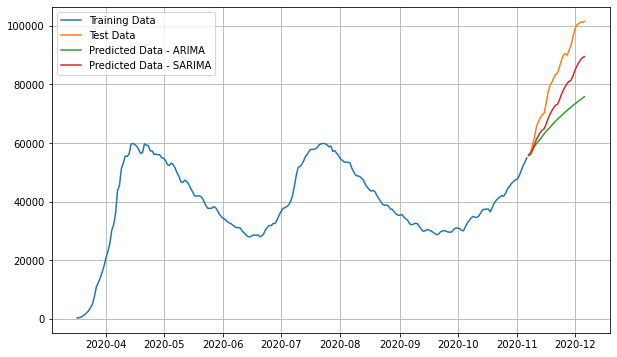

In [85]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.legend(loc='best')
plt.grid();

In SARIMA we can observe weekly fluctuations. Though it looks better than ARIMA still we consider it underforecasted 

### It can be observed that SARIMA model is showing good seasonal considerations

## finding RSMA and MAPE

In [86]:
rmse = sqrt(mean_squared_error(test.Hospitalized,SARIMA_predictions))
print(rmse)

9762.059595532262


In [87]:
mape = MAPE(test.Hospitalized,SARIMA_predictions)
print(mape)

10.203650539824629


In [88]:
resultsDfsarima = pd.DataFrame({'Test RMSE': rmse, 'Test MAPE':mape}
                           ,index=['SARIMA(1, 1, 3)(1, 1, 3)7'])

resultsDf = pd.concat([resultsDf, resultsDfsarima])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(3,1,3)",17232.760418,17.040450
"SARIMA(1, 1, 3)(1, 1, 3)7",9762.059596,10.203651


## model residual analysis

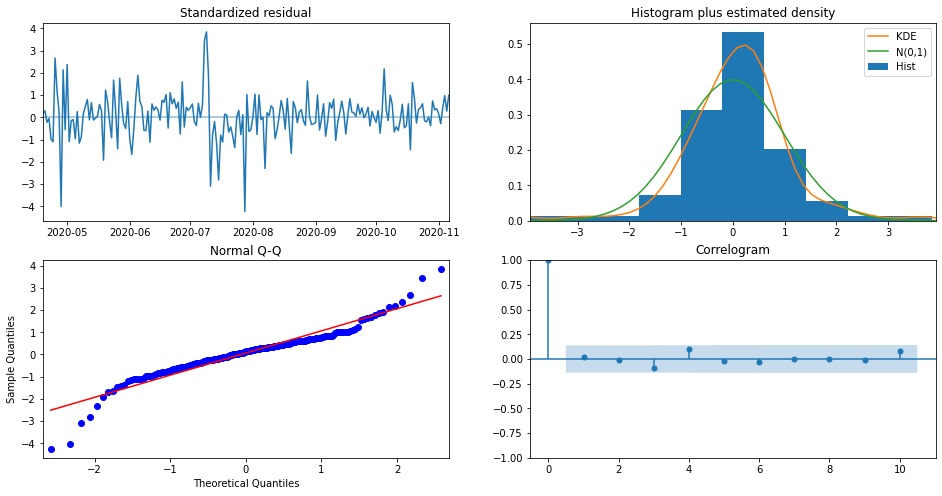

In [89]:
model_Sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

### It can be observed that Model residuals are normally distributed and ACF plot also confirms that residuals are random

## We will build SARIMAX model for forecasting Hospitalized count. For SARIMAX model,we will use Positive count as exog variable

Considering Positive as Exogenic Variable

In [90]:
ex=df[['Positive']]

In [91]:
ex

,Positive
Time_Stamp,
2020-03-17,10021
2020-03-18,13385
2020-03-19,18085
2020-03-20,24197
2020-03-21,31013
...,...
2020-12-02,13711156
2020-12-03,13921360
2020-12-04,14146191


## splitting exog variable into training and testing set

In [92]:
ex_train             = ex[:train_end]
ex_test              = ex[train_end + timedelta(days=1):test_end]

### Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [93]:
dfObj3 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
dfObj3

,param,seasonal,AIC


## model parameter selection using hypertuning

In [ ]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,exog=ex_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMAX = mod.fit()
        print('SARIMA{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
        dfObj3 = dfObj3.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)

SARIMA(0, 0, 0)(0, 0, 0, 7) - AIC:6471.655187973391
SARIMA(0, 0, 0)(0, 0, 1, 7) - AIC:5112.807499150445
SARIMA(0, 0, 0)(0, 0, 2, 7) - AIC:4847.502366793572
SARIMA(0, 0, 0)(0, 0, 3, 7) - AIC:4610.7326153267495
SARIMA(0, 0, 0)(0, 1, 0, 7) - AIC:5674.544765008526
SARIMA(0, 0, 0)(0, 1, 1, 7) - AIC:4459.058775141027
SARIMA(0, 0, 0)(0, 1, 2, 7) - AIC:4318.7933155601695
SARIMA(0, 0, 0)(0, 1, 3, 7) - AIC:4083.8947041410233
SARIMA(0, 0, 0)(1, 0, 0, 7) - AIC:4686.832792303774
SARIMA(0, 0, 0)(1, 0, 1, 7) - AIC:4707.483925219704
SARIMA(0, 0, 0)(1, 0, 2, 7) - AIC:4434.389172667785
SARIMA(0, 0, 0)(1, 0, 3, 7) - AIC:4262.94902140675
SARIMA(0, 0, 0)(1, 1, 0, 7) - AIC:4366.739432168464
SARIMA(0, 0, 0)(1, 1, 1, 7) - AIC:4392.8548884500415
SARIMA(0, 0, 0)(1, 1, 2, 7) - AIC:4243.121983265416
SARIMA(0, 0, 0)(1, 1, 3, 7) - AIC:3889.9496529347407
SARIMA(0, 0, 0)(2, 0, 0, 7) - AIC:4340.395729269396
SARIMA(0, 0, 0)(2, 0, 1, 7) - AIC:4444.778555882316
SARIMA(0, 0, 0)(2, 0, 2, 7) - AIC:4478.778202951576
SARIMA(0

SARIMA(0, 1, 0)(3, 1, 1, 7) - AIC:3367.4940026495424
SARIMA(0, 1, 0)(3, 1, 2, 7) - AIC:3367.403867734085
SARIMA(0, 1, 0)(3, 1, 3, 7) - AIC:3341.8447046061037
SARIMA(0, 1, 1)(0, 0, 0, 7) - AIC:3909.7467704762844
SARIMA(0, 1, 1)(0, 0, 1, 7) - AIC:3765.6845090988586
SARIMA(0, 1, 1)(0, 0, 2, 7) - AIC:3594.916791615449
SARIMA(0, 1, 1)(0, 0, 3, 7) - AIC:3374.256077852267
SARIMA(0, 1, 1)(0, 1, 0, 7) - AIC:3777.6529213766435
SARIMA(0, 1, 1)(0, 1, 1, 7) - AIC:3632.221537832161
SARIMA(0, 1, 1)(0, 1, 2, 7) - AIC:3452.492539991027
SARIMA(0, 1, 1)(0, 1, 3, 7) - AIC:3284.645947320005
SARIMA(0, 1, 1)(1, 0, 0, 7) - AIC:3784.2622769429463
SARIMA(0, 1, 1)(1, 0, 1, 7) - AIC:3723.468066406467
SARIMA(0, 1, 1)(1, 0, 2, 7) - AIC:3611.663415413402
SARIMA(0, 1, 1)(1, 0, 3, 7) - AIC:3398.304473520985
SARIMA(0, 1, 1)(1, 1, 0, 7) - AIC:3669.585335739872
SARIMA(0, 1, 1)(1, 1, 1, 7) - AIC:3620.4953357639015
SARIMA(0, 1, 1)(1, 1, 2, 7) - AIC:3463.504979055962
SARIMA(0, 1, 1)(1, 1, 3, 7) - AIC:3329.8542230322732
SARI

## sorting parameters for AIC score

In [183]:
dfObj3.sort_values(by=['AIC'])

,param,seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 7)",3536.918928
59,"(1, 1, 1)","(0, 1, 1, 7)",3537.161487
62,"(1, 1, 1)","(1, 1, 0, 7)",3593.484822
51,"(1, 1, 0)","(0, 1, 1, 7)",3599.278102
55,"(1, 1, 0)","(1, 1, 1, 7)",3610.115694
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 7)",5112.807499
8,"(0, 0, 1)","(0, 0, 0, 7)",5236.951256
13,"(0, 0, 1)","(1, 0, 1, 7)",5340.504099
2,"(0, 0, 0)","(0, 1, 0, 7)",5674.544765


## We will build SARIMAX model of order (1,1,3)(0,1,3,7)

In [184]:
model = sm.tsa.statespace.SARIMAX(train,exog=ex_train,
                                order=(1,1,3),
                                seasonal_order=(1,1,3,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_sarimax = model.fit()
print(model_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Hospitalized   No. Observations:                  235
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1762.459
Date:                           Wed, 10 Mar 2021   AIC                           3536.919
Time:                                   19:00:18   BIC                           3557.226
Sample:                               03-17-2020   HQIC                          3545.121
                                    - 11-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Positive       0.0200      0.014      1.432      0.152      -0.007       0.047
ar.L1          0.9437      0.021     44.185

### model predictions

In [185]:
SARIMAX_predictions=model_sarimax.predict(start=pred_start, end=pred_end,exog=ex_test)

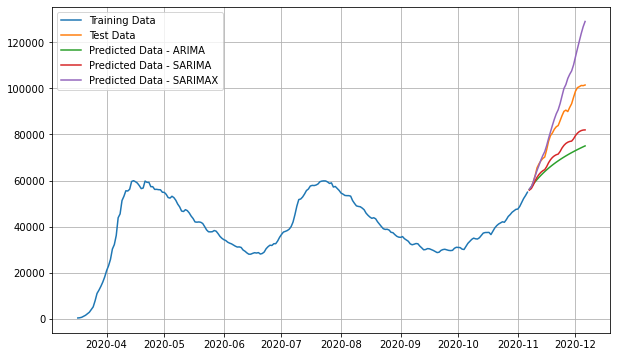

In [186]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.plot(test.index,SARIMAX_predictions,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.grid();

### SARIMAX model is predicting results quite close to actual data

But the observation is Overforecasted

## Residual analysis

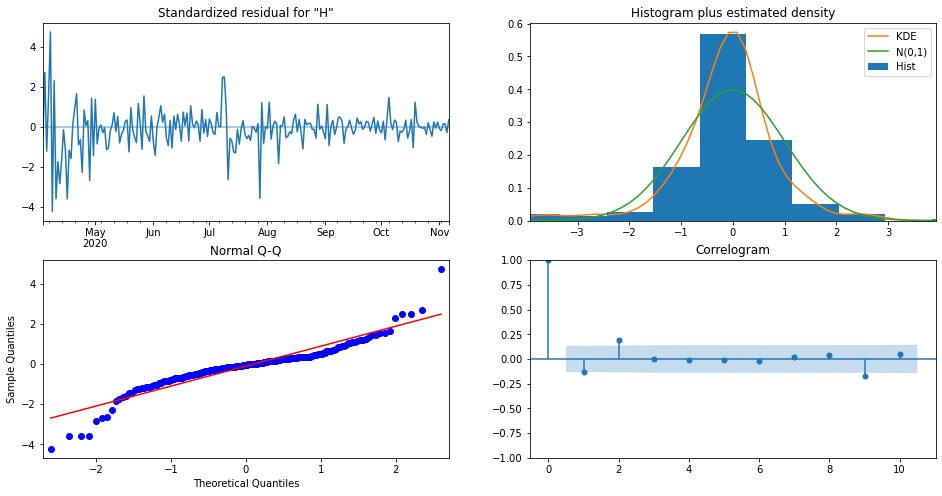

In [187]:
model_sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

### It can be observed that Model residuals are normally distributed and ACF plot also confirms that residuals are random

## Finding RSMA and MAPE

In [188]:
rmse = sqrt(mean_squared_error(test.Hospitalized,SARIMAX_predictions))
print(rmse)

11709.443638505812


In [189]:
mape = MAPE(test.Hospitalized,SARIMAX_predictions)
print(mape)

8.98782952467951


In [190]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['SARIMAX(1, 1, 1)(0, 1, 1)7'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",17222.569806,16.677050
"SARIMA(1, 1, 1)(1, 1, 1)7",12901.969207,12.732867
"SARIMAX(1, 1, 1)(0, 1, 1)7",11709.443639,8.987830


## As series has seasonality and trend, lets try H-W model for forecasting Hospitalized count

In [191]:
model_TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')

In [192]:
model_TES = model_TES.fit(optimized=True)
model_TES.summary()

Dep. Variable:,Hospitalized,No. Observations:,235
Model:,ExponentialSmoothing,SSE,139965968.248
Optimized:,True,AIC,3146.871
Trend:,Additive,BIC,3184.927
Seasonal:,Additive,AICC,3148.518
Seasonal Periods:,7,Date:,"Wed, 10 Mar 2021"
Box-Cox:,False,Time:,19:00:20
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8947529,alpha,True
smoothing_trend,0.4089930,beta,True


In [193]:
TES_predictions =  model_TES.forecast(len(test))

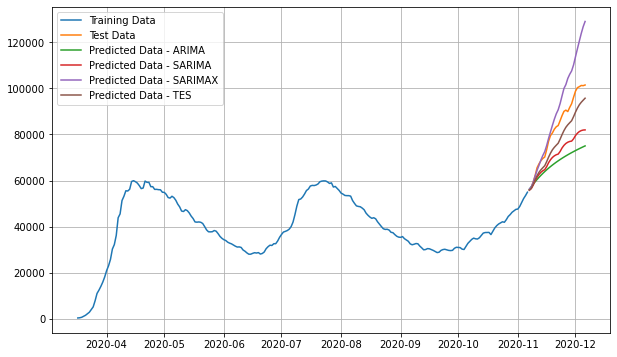

In [194]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,df_fc['Hospitalized_forecast'],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.plot(test.index,SARIMAX_predictions,label='Predicted Data - SARIMAX')
plt.plot(test.index,TES_predictions,label='Predicted Data - TES')
plt.legend(loc='best')
plt.grid();

## finding RSME and MAPE

In [195]:
rmse = sqrt(mean_squared_error(test.Hospitalized,TES_predictions))
print(rmse)

6473.132560612063


In [196]:
mape = MAPE(test['Hospitalized'].values,TES_predictions.values)
print(mape)

6.9189679523465415


In [197]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(1,1,1)",17222.569806,16.677050
"SARIMA(1, 1, 1)(1, 1, 1)7",12901.969207,12.732867
"SARIMAX(1, 1, 1)(0, 1, 1)7",11709.443639,8.987830
TES,6473.132561,6.918968


## Based on MAPE, selecting H-W model

In [198]:
model_TES = ExponentialSmoothing(df_final,trend='additive',seasonal='additive',initialization_method='estimated')

In [199]:
model_TES = model_TES.fit(optimized=True)

In [202]:
model_TES.summary()

Dep. Variable:,Hospitalized,No. Observations:,265
Model:,ExponentialSmoothing,SSE,162264376.345
Optimized:,True,AIC,3553.127
Trend:,Additive,BIC,3592.504
Seasonal:,Additive,AICC,3554.577
Seasonal Periods:,7,Date:,"Wed, 10 Mar 2021"
Box-Cox:,False,Time:,19:05:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8903442,alpha,True
smoothing_trend,0.4020128,beta,True


In [200]:
forecast= model_TES.forecast(30)

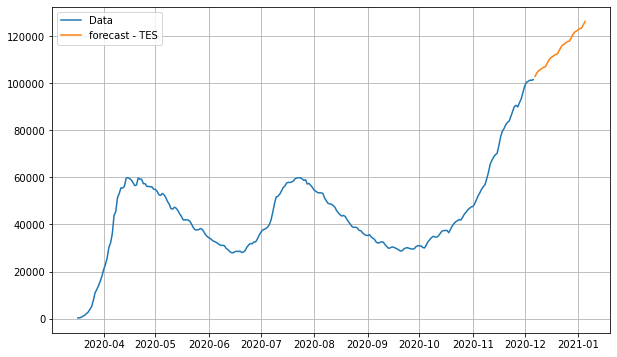

In [201]:
plt.plot(df_final,label='Data')
plt.plot(forecast,label='forecast - TES')
plt.legend(loc='best')
plt.grid();

# END